In [1]:
from models import AlexNet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

In [2]:
batch_size = 64

#preparing the train, validation and test dataset
# 데이터 전처리
# ImageNet 데이터 셋 가져오기
# 2. Dataset, 4.1 Data Augmentation 참고
# ImageNet 대신 CIFAR-10 데이터 셋 사용
train_datasets = datasets.CIFAR10(root='../data/CIFAR10',
                                  train=True,
                                  transform=transforms.Compose([
                                      transforms.Resize((227,227)),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  ]),
                                  download=True)
test_datasets = datasets.CIFAR10(root='../data/CIFAR10',
                                 train=True,
                                 transform=transforms.Compose([
                                     transforms.Resize((227,227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ]),
                                 download=True)

val_size = 10000
train_size = len(train_datasets) - val_size
train_datasets, val_datasets = torch.utils.data.random_split(train_datasets, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_datasets,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_datasets,
                                          batch_size=batch_size,
                                          shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_datasets,
                                          batch_size=batch_size,
                                          shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
625
157
782


In [3]:
def custom_imshow(dataloader):
    for images, _ in dataloader:
        print('images.shape:', images.shape)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
        break

이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


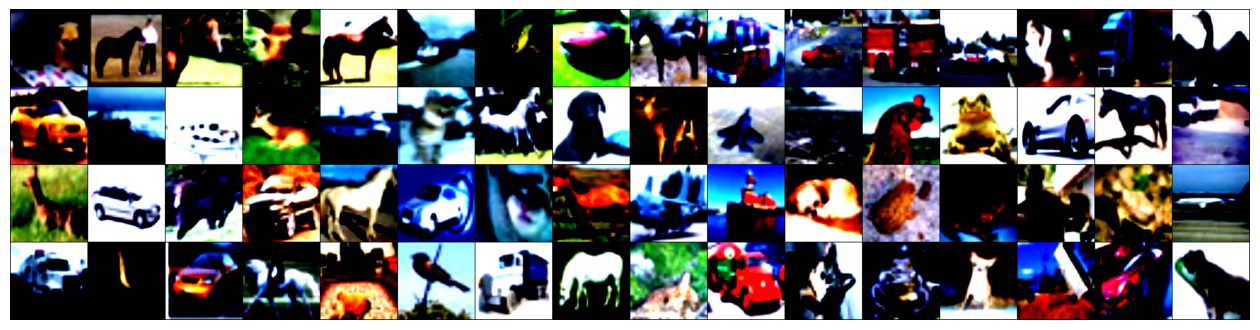

In [4]:
custom_imshow(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


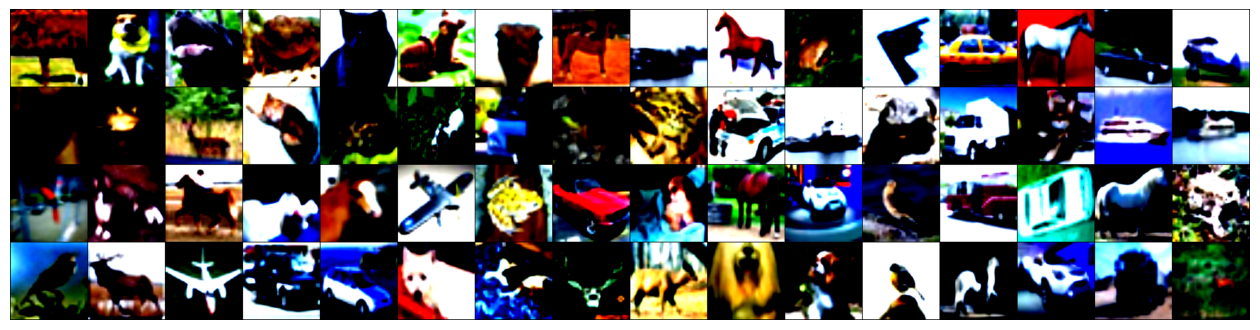

In [5]:
custom_imshow(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


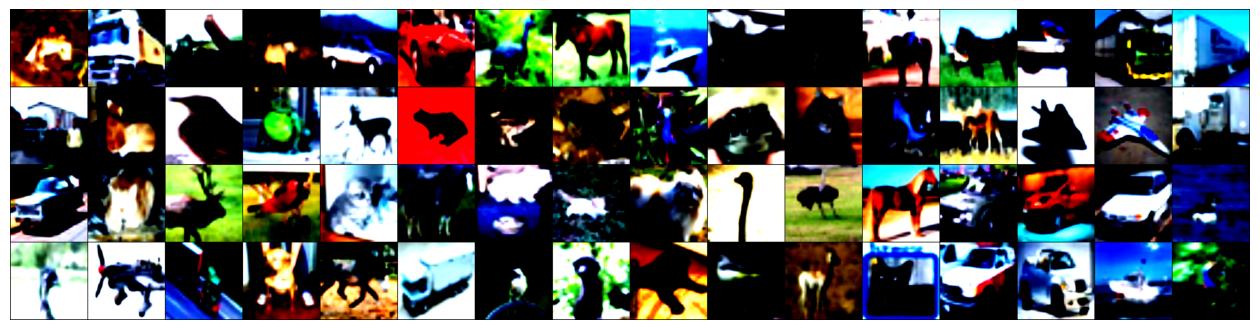

In [6]:
custom_imshow(test_loader)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AlexNet(10).to(device)
summary(model, (3, 227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [4]:
torch.cuda.empty_cache()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 훈련
model.train()

train_loss_list = []
train_accuracy_list = []

epochs = 50
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0

    with tqdm(train_loader,
              total=train_loader.__len__(),
              unit="batch") as progress_bar:
        for batch_idx, (data, target) in enumerate(progress_bar, start=1):
            data = data.to(device)
            target = target.to(device)

            # 순전파
            y_pred = model(data)
            loss = loss_fn(y_pred, target)

            # 역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
           
            # 배치에서의 총 loss 계산해서 train_loss에 더하기
            train_loss += loss.item()

            # accuracy 계산
            _, pred = y_pred.max(dim=1)
            correct_counts = pred.eq(target.data.view_as(pred))
            # correct_counts를 float으로 변경 후 평균 계산
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # 배치에서의 accuracy를 계산해서 train_accuray에 더하기
            train_acc += acc.item()
            
            progress_bar.set_description(f'[Traning] Epoch: {epoch+1}, loss: {loss.item():.4f}')
            
        # 검증
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for batch_idx, (data, target) in enumerate(val_loader):
                data = data.to(device)
                target = target.to(device)

                y_pred = model(data)
                _, pred = y_pred.max(dim=1)
                num_correct += (pred == target).sum()
                num_samples += pred.size(0)
            print(
                f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
            )
            
        
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    train_acc /= len(train_loader.dataset)
    train_accuracy_list.append(train_acc)


[Traning] Epoch: 1, loss: 1.2180: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.49batch/s]


Got 5390 / 10000 with accuracy 53.90


[Traning] Epoch: 2, loss: 1.1758: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 6392 / 10000 with accuracy 63.92


[Traning] Epoch: 3, loss: 0.7516: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.50batch/s]


Got 7039 / 10000 with accuracy 70.39


[Traning] Epoch: 4, loss: 0.6397: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 7243 / 10000 with accuracy 72.43


[Traning] Epoch: 5, loss: 0.8047: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.49batch/s]


Got 7602 / 10000 with accuracy 76.02


[Traning] Epoch: 6, loss: 0.4318: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 7643 / 10000 with accuracy 76.43


[Traning] Epoch: 7, loss: 0.2962: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.45batch/s]


Got 7911 / 10000 with accuracy 79.11


[Traning] Epoch: 8, loss: 0.3201: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.50batch/s]


Got 7870 / 10000 with accuracy 78.70


[Traning] Epoch: 9, loss: 0.3682: 100%|███████████████████████████████████████████| 625/625 [01:13<00:00,  8.54batch/s]


Got 8151 / 10000 with accuracy 81.51


[Traning] Epoch: 10, loss: 0.4475: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8071 / 10000 with accuracy 80.71


[Traning] Epoch: 11, loss: 0.5206: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 8117 / 10000 with accuracy 81.17


[Traning] Epoch: 12, loss: 0.2973: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.54batch/s]


Got 8178 / 10000 with accuracy 81.78


[Traning] Epoch: 13, loss: 0.2823: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8262 / 10000 with accuracy 82.62


[Traning] Epoch: 14, loss: 0.3964: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8319 / 10000 with accuracy 83.19


[Traning] Epoch: 15, loss: 0.3288: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.50batch/s]


Got 8244 / 10000 with accuracy 82.44


[Traning] Epoch: 16, loss: 0.2431: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8294 / 10000 with accuracy 82.94


[Traning] Epoch: 17, loss: 0.2495: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8264 / 10000 with accuracy 82.64


[Traning] Epoch: 18, loss: 0.2138: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 8328 / 10000 with accuracy 83.28


[Traning] Epoch: 19, loss: 0.1329: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8310 / 10000 with accuracy 83.10


[Traning] Epoch: 20, loss: 0.2720: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 8354 / 10000 with accuracy 83.54


[Traning] Epoch: 21, loss: 0.1170: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.49batch/s]


Got 8297 / 10000 with accuracy 82.97


[Traning] Epoch: 22, loss: 0.1617: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8336 / 10000 with accuracy 83.36


[Traning] Epoch: 23, loss: 0.0761: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 8412 / 10000 with accuracy 84.12


[Traning] Epoch: 24, loss: 0.2279: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.44batch/s]


Got 8291 / 10000 with accuracy 82.91


[Traning] Epoch: 25, loss: 0.0535: 100%|██████████████████████████████████████████| 625/625 [01:15<00:00,  8.25batch/s]


Got 8347 / 10000 with accuracy 83.47


[Traning] Epoch: 26, loss: 0.0889: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8385 / 10000 with accuracy 83.85


[Traning] Epoch: 27, loss: 0.0920: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.54batch/s]


Got 8365 / 10000 with accuracy 83.65


[Traning] Epoch: 28, loss: 0.0386: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.52batch/s]


Got 8361 / 10000 with accuracy 83.61


[Traning] Epoch: 29, loss: 0.0889: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8304 / 10000 with accuracy 83.04


[Traning] Epoch: 30, loss: 0.1051: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.42batch/s]


Got 8361 / 10000 with accuracy 83.61


[Traning] Epoch: 31, loss: 0.1201: 100%|██████████████████████████████████████████| 625/625 [01:17<00:00,  8.08batch/s]


Got 8370 / 10000 with accuracy 83.70


[Traning] Epoch: 32, loss: 0.2672: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.35batch/s]


Got 8325 / 10000 with accuracy 83.25


[Traning] Epoch: 33, loss: 0.0288: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.51batch/s]


Got 8405 / 10000 with accuracy 84.05


[Traning] Epoch: 34, loss: 0.0625: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.49batch/s]


Got 8396 / 10000 with accuracy 83.96


[Traning] Epoch: 35, loss: 0.1377: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.34batch/s]


Got 8489 / 10000 with accuracy 84.89


[Traning] Epoch: 36, loss: 0.0521: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.38batch/s]


Got 8349 / 10000 with accuracy 83.49


[Traning] Epoch: 37, loss: 0.0380: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.38batch/s]


Got 8431 / 10000 with accuracy 84.31


[Traning] Epoch: 38, loss: 0.0949: 100%|██████████████████████████████████████████| 625/625 [01:12<00:00,  8.59batch/s]


Got 8322 / 10000 with accuracy 83.22


[Traning] Epoch: 39, loss: 0.1446: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.43batch/s]


Got 8398 / 10000 with accuracy 83.98


[Traning] Epoch: 40, loss: 0.0178: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.49batch/s]


Got 8372 / 10000 with accuracy 83.72


[Traning] Epoch: 41, loss: 0.1403: 100%|██████████████████████████████████████████| 625/625 [01:12<00:00,  8.61batch/s]


Got 8387 / 10000 with accuracy 83.87


[Traning] Epoch: 42, loss: 0.0600: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.50batch/s]


Got 8446 / 10000 with accuracy 84.46


[Traning] Epoch: 43, loss: 0.0607: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.54batch/s]


Got 8397 / 10000 with accuracy 83.97


[Traning] Epoch: 44, loss: 0.0585: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.55batch/s]


Got 8344 / 10000 with accuracy 83.44


[Traning] Epoch: 45, loss: 0.0367: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.46batch/s]


Got 8349 / 10000 with accuracy 83.49


[Traning] Epoch: 46, loss: 0.0907: 100%|██████████████████████████████████████████| 625/625 [01:15<00:00,  8.23batch/s]


Got 8432 / 10000 with accuracy 84.32


[Traning] Epoch: 47, loss: 0.0757: 100%|██████████████████████████████████████████| 625/625 [01:16<00:00,  8.18batch/s]


Got 8429 / 10000 with accuracy 84.29


[Traning] Epoch: 48, loss: 0.0465: 100%|██████████████████████████████████████████| 625/625 [01:14<00:00,  8.37batch/s]


Got 8384 / 10000 with accuracy 83.84


[Traning] Epoch: 49, loss: 0.1313: 100%|██████████████████████████████████████████| 625/625 [01:15<00:00,  8.29batch/s]


Got 8467 / 10000 with accuracy 84.67


[Traning] Epoch: 50, loss: 0.0351: 100%|██████████████████████████████████████████| 625/625 [01:13<00:00,  8.45batch/s]


Got 8397 / 10000 with accuracy 83.97


In [5]:
# 모델 저장
torch.save(model.state_dict(), './alexnet_cifar10.pt')

In [10]:
model = AlexNet(10)
model.load_state_dict(torch.load('./alexnet_cifar10.pt'))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): L

In [11]:
# 테스트
acc = 0
with torch.no_grad():
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        y_pred = model(data)

        _, pred = y_pred.max(dim=1)

        acc += (pred == target).sum().item()

    acc /= len(test_loader.dataset)
print('accuracy: {:.4f}'.format(acc))

accuracy: 0.9705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: frog truck truck deer 
predict: frog truck truck deer 


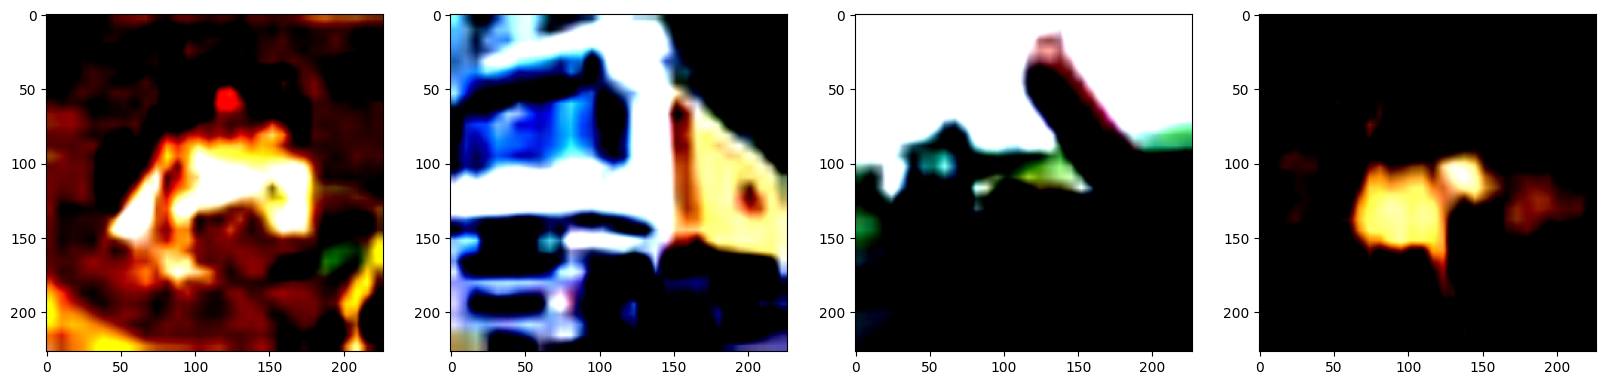

In [22]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image, label = next(iter(test_loader))
label_str = ''
pred_label_str = ''

plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    
    img = image[i]
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    y_pred = model(image.to(device))
    pred_label = torch.argmax(y_pred, dim=1)
    
    label_str += label_names[label[i].item()] + ' '
    pred_label_str += label_names[pred_label[i].item()] + ' '

print('label: {}\npredict: {}'.format(label_str, pred_label_str))
plt.show()